# Variogram analysis and kriging for data in 1D

Interpolate a data set in 1D, using simple or ordinary kriging. Starting from a data set in 1D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

**Note:** most of the tools illustrated below can also be used for data in 2D or 3D assuming omni-directional covariance / variogram models.


## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Preparation - build a data set in 1D
A data set in 1D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define the *reference* covariance model in 1D (class `geone.covModel.CovModel1D`, see jupyter notebook `ex_grf_1d`).

In [2]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':7., 'r':100}),   # elementary contribution
    ('exponential', {'w':2.5, 'r':50}), # elementary contribution
    ('nugget', {'w':0.5})               # elementary contribution
    ], name='ref model')

In [3]:
cov_model_ref

Covariance model 1D: (Name = ref model)
   3 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 7.0,  r = 100
   Elementary contribution 1: type : exponential
      parameters:  w = 2.5,  r = 50
   Elementary contribution 2: type : nugget
      parameters:  w = 0.5

Generate a gaussian random field in 1D (see function `geone.grf.grf1D`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (1-dimensional array of length `n`),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx = 1000 # number of cells
dx = 0.5  # cell unit
ox = 0.0  # origin
# xmin, xmax = ox, ox + nx*dx # bounds of the simulation domain

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf1D(cov_model_ref, nx, dx, ox, nreal=1, printInfo=False) # 2d-array of shape 1 x nx

# Extract n points from the reference simulation
n = 25 # number of data points
ind = np.random.choice(nx, size=n, replace=False) # indexes of extracted grid cells
x = ox + (ind + 0.5)*dx # coordinates of data points (centers of the extracted grid cells)
#x = ox + (ind + np.random.random(n))*dx # coordinates of data points (within the extracted grid cells)
v = ref[0,ind] # value at data points

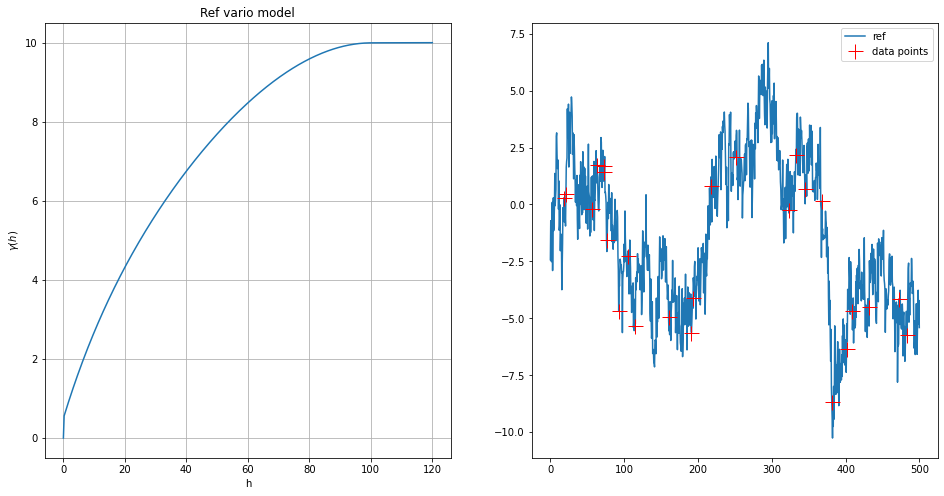

In [5]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')

plt.subplot(1,2,2)
plt.plot(ox + (np.arange(nx)+0.5)*dx, ref[0], label='ref')
plt.plot(x, v, 'r+', markersize=15, label='data points')
plt.legend()
plt.show()

## Start from a data set in 1D
- `n`: number of data points
- `x`: 1-dimensional array of length `n`: locations of data points
- `v`: 1-dimensional array of length `n`: values at data points

Visualise the data set and the histogram of values.

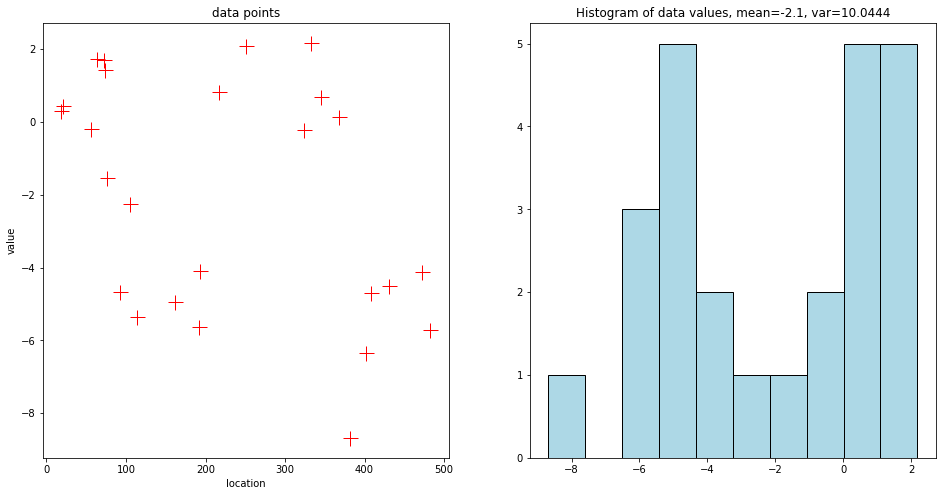

In [6]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(x, v, 'r+', markersize=15)
plt.xlabel('location')
plt.ylabel('value')
plt.title('data points')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram cloud
Compute the variogram cloud. The pair of the i-th and j-th data points gives the point $(h(i,j), g(i,j))$ in the variogram cloud, where
- $h(i,j) = \vert\vert x(i)-x(j)\vert\vert$ is the distance between $x(i)$ and $x(j)$ (lag)
- $g(i,j) = 1/2 \cdot (v(i)-v(j))^2)$ is the corresponding $\gamma$ value.

The function `geone.covModel.variogramCloud1D` returns two 1-dimensional arrays `h` and `g` of same length `npair` containing the coordinates of the points in the variogram cloud. The maximal distance between two data points to be integrated in the variogram cloud can be specified by the keyword argument `hmax`. Note that a plot of the variogram cloud is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* variogram cloud.

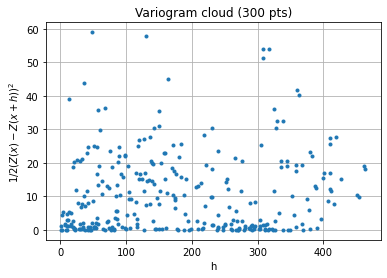

In [7]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)
plt.show()

### Experimental variogram
Compute the experimental variogram. It is obtained from the variogram cloud by computing the mean points of variogram cloud points within vertical bands (classes for the lags). A class for a lag is an interval along the $h$-axis. 

The function `geone.covModel.variogramExp1D` returns three 1-dimensional arrays `hexp`, `gexp`, and `cexp` of same length (number of classes), where `hexp` and `gexp` contain the coordinates of the mean points of each class and `cexp` the number (counter) of points in each class.

The variogram cloud (if already computed) can be passed directly to the function `geone.covModel.variogramExp1D` via the keyword argument `geone.covModel.variogramCloud`: in this case, the arguments `x`, `v`, (and optional `hmax`) are not used. The classes can be defined in several ways: specifying the number of classes (`ncla`) / specifying the class centers (`cla_center`) / specifying the class length(s) (`cla_length`) (in particular overlapping classes are possible), see doc of the function). Note that a plot of the experimental variogram is made by default (keyword argument `make_plot=True`) with the counters displayed (keyword argument `show_count=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* experimental variogram.

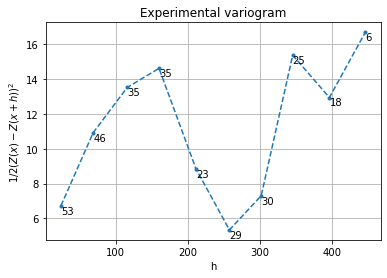

In [8]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

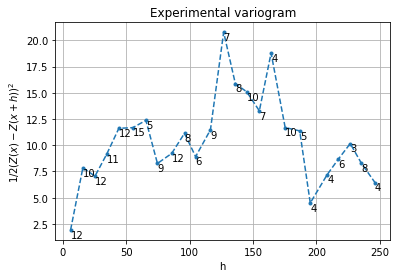

In [9]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, cla_center=np.arange(5, 250, 10))
plt.show()

Note that the function `geone.covModel.plot_variogramExp1D` allows to plot an experimental variogram (already computed): `geone.covModel.plot_variogramExp1D(hexp, gexp, cexp)` gives the plot above.

### Model fitting
The function `geone.covModelcovModel1D_fit` allows to fit a covariance / variogram model in 1D to given data.

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 1D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points (*i.e.* fit to the points of the variogram cloud). Hence, the fitting does not depend on the experimental variogram, *i.e.* on the choice of the classes for the lags.

The function `geone.covModelcovModel1D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function fits an *omni-directional* model.

/home/julien/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


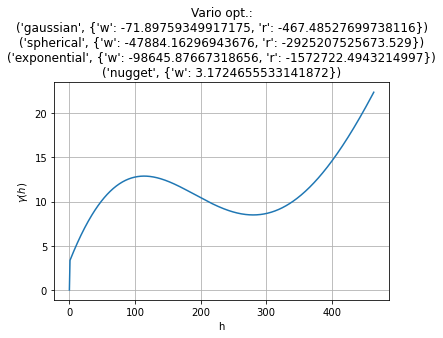

In [10]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize)
plt.show()

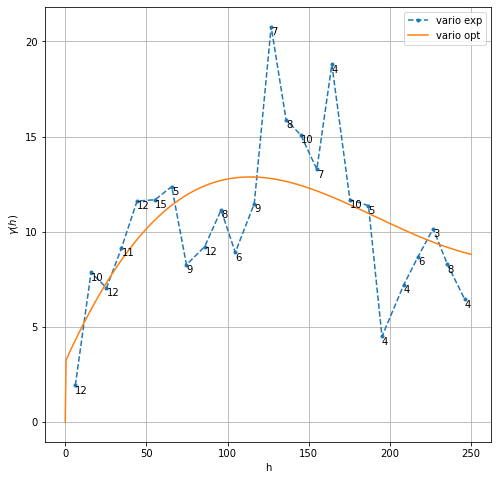

In [11]:
plt.figure(figsize=(8,8))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
plt.legend()
plt.show()

#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `geone.covModelcovModel1D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

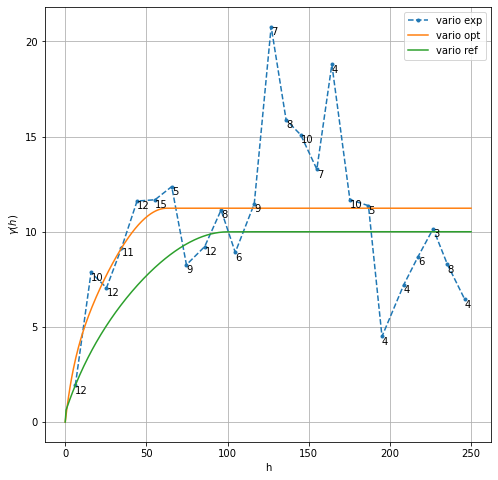

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 4.984362628402919e-08,  r = 55.700167573155234
   Elementary contribution 1: type : spherical
      parameters:  w = 8.208187586008494,  r = 62.57538849544766
   Elementary contribution 2: type : exponential
      parameters:  w = 3.026733565226654,  r = 16.553635316111635
   Elementary contribution 3: type : nugget
      parameters:  w = 0.001042160790138681

In [12]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize,# hmax=300,
                                                 bounds=([ 0,   0,  0,   0,  0,   0,  0], 
                                                         [20, 300, 20, 300, 20, 300, 20]),
                                                 make_plot=False)
# bounds are given for:
#  index 0: parameter 'w' of gaussian contribution
#  index 1: parameter 'r' of gaussian contribution
#  index 2: parameter 'w' of spherical contribution
#  index 3: parameter 'r' of spherical contribution
#  index 4: parameter 'w' of exponential contribution
#  index 5: parameter 'r' of exponential contribution
#  index 6: parameter 'w' of nugget contribution

# Compare variogram exp. / variogram opt. / variogram ref
plt.figure(figsize=(8,8))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25, label='vario exp') # equiv.
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=250, label='vario ref')
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. Given a data set and a covariance model, the kriging estimate $Z^*(x)$ and standard deviation $\sigma^*(x)$ are computed at each data point $x$, based on the data set without that data point $(x, Z(x))$ and the given covariance model.

The interpolator (function) used is passed by the keyword argument `interpolator` of the function `geone.covModel.cross_valid_loo`; the keyword argument `interpolator_kwargs` is a dictionary containing the keyword arguments that are passed to the function `interpolator`. By default:
- `interpolator=geone.covModel.krige`, `interpolator_kwargs={}`: the function `geone.covModel.krige` is used as interpolator with default keyword arguments, *i.e.* simple_kriging is used with mean value at the data points taken into account (*i.e* without the removed data point)

To use ordinary kriging as interpolator, set `interpolator_kwargs={'method':'ordinary_kriging'}` (see below details about the function `geone.covModel.krige`).

Two statisic tests are performed on the normalized error $(Z^*(x)-Z(x))/\sigma^*(x)$; with $n$ the number of data points:
1. normal law test for mean of normalized error: mean of normalized error times $\sqrt{n-1}$ should follow approximately a law $\mathcal{N}(0,1)$ (CLT),
2. Chi2 test for sum of squares of normalized error: it should follow a law Chi2 with $n-1$ degrees of freedom,

The statistic test passes with success if the obtained value is within the central interval covering the $(1-confidence)$ part of the corresponding distribution, otherwise the test fails. The confidence is then a float number in $[0,1]$ passed to the function via the keyword argument `confidence` (by default: $5\%$). 

The function returns a tuple of length 4, `(cv_est, cv_std, test_normal, test_chi2)`:
- `cv_est` and `cv_std` are one dimensional numpy arrays containing respectively the cross-validation estimates $Z^*(x)$ and standard deviation $\sigma^*(x)$ for every data point,
- `test_normal` and `test_chi2` are booleans indicating respectively if the normal law test (1) and if the Chi2 test (2) have been pased with success (`True`), or not (`False`). 

Note that a plot of the results is made if the keyword argument `make_plot` is set to `True` (default value).

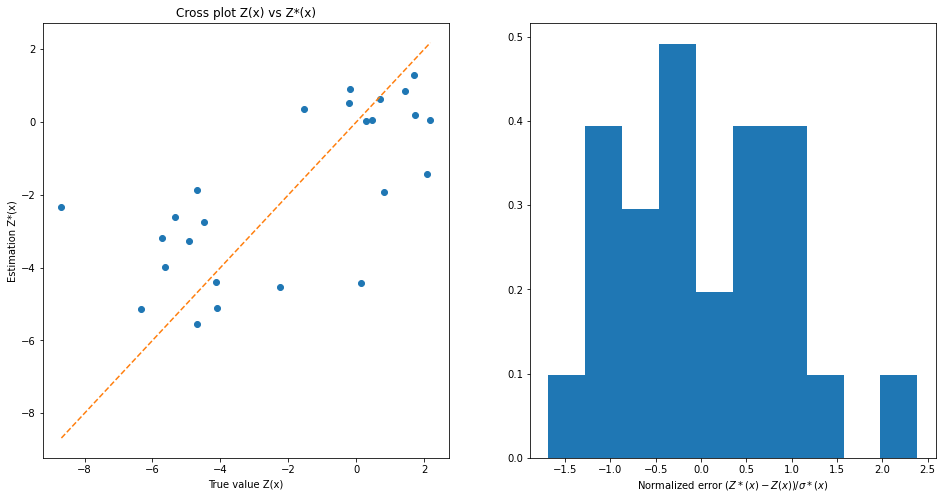

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [13]:
# Interpolation by simple kriging
cv_est1, cv_std1, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                                       #interpolator_kwargs={'mean':np.mean(v)},
                                                                       make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

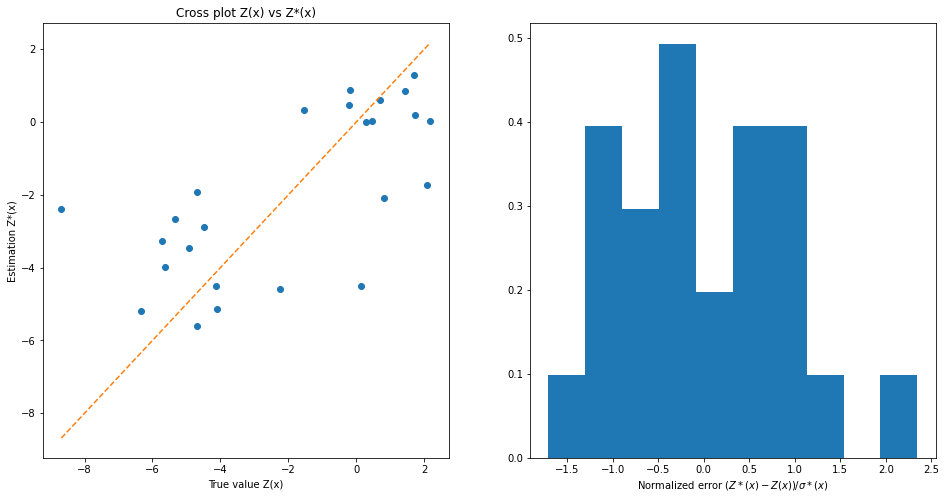

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [14]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                interpolator_kwargs={'method':'ordinary_kriging'},
                                                make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

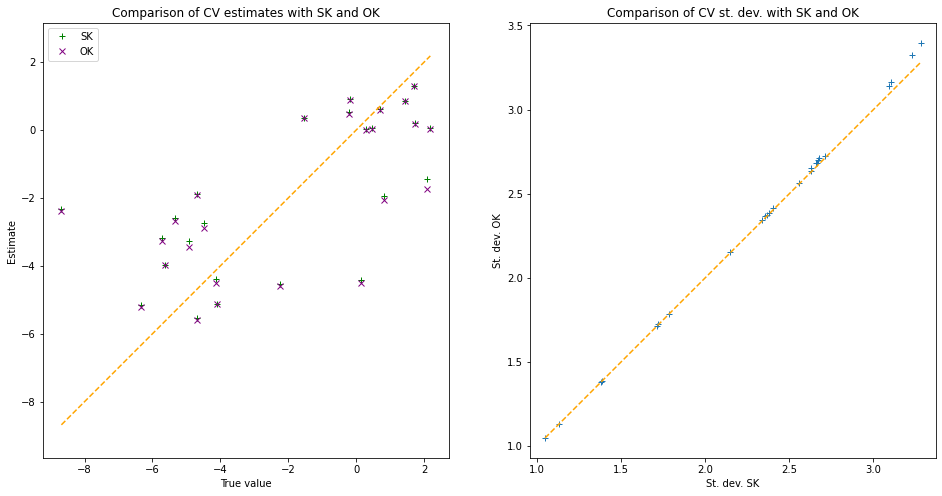

In [15]:
# Comparison of cross-validation with simple and kriging and ordinary kriging
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('True value')
plt.ylabel('Estimate')
plt.legend()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
The function `geone.covModel.krige(x, v, xu, cov_model, method='simple_kriging', mean=None)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:
- `method='simple_kriging'` (default): simple kriging is used, with the mean automatically set to the mean of the data values (`mean=None`); a specified mean value or array (for non-stationary mean) can be set manually with the keyword argument `mean`.
- `method='ordinary_kriging'`: ordinary kriging is used (the keyword argument `mean` must be `None` in this case)

For data in 1D:
- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the interpolation is done.

In return:
- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`.

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).

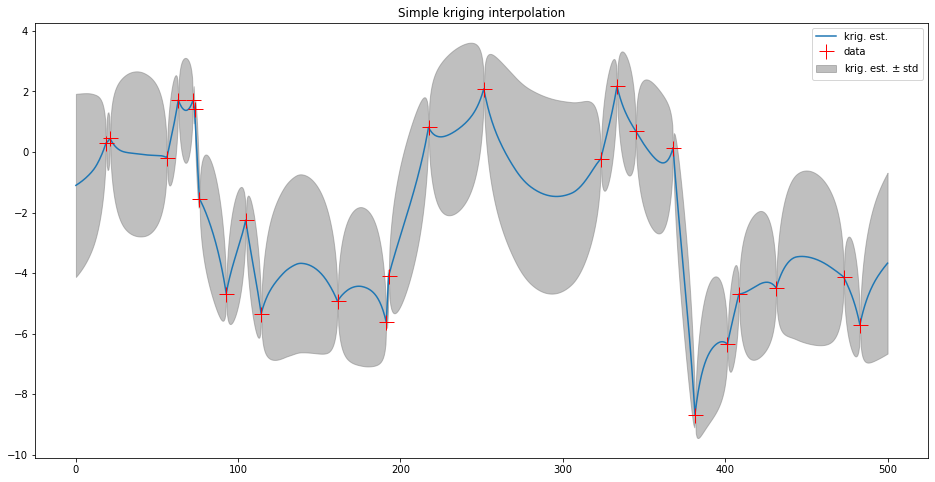

In [16]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*dx

# Simple kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.title('Simple kriging interpolation')
plt.show()

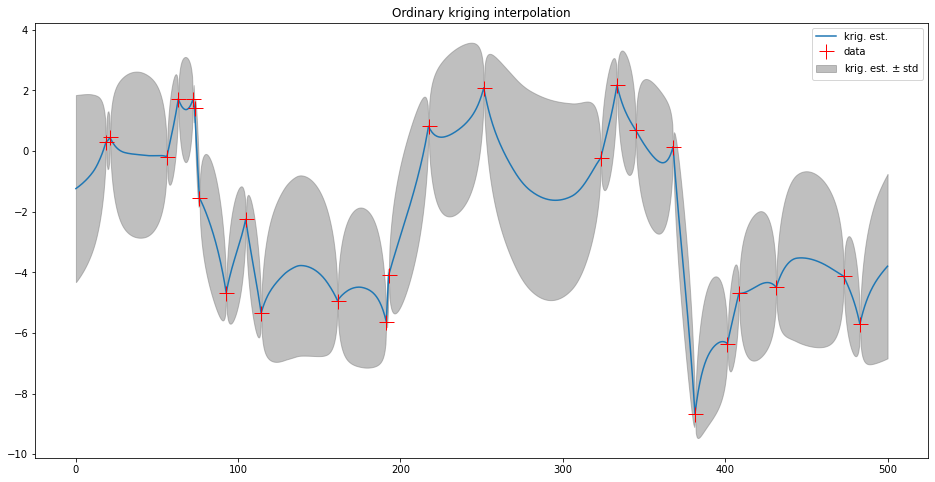

In [17]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*dx

# Ordinary kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.title('Ordinary kriging interpolation')
plt.show()

## Simulation based on simple or ordinary kriging: function `geone.covModel.sgs`
The function `geone.covModel.sgs(x, v, xu, cov_model, method='simple_kriging', mean=None, nreal=1)` performs sequential gaussian simulation (SGS) based on simple or ordinary kriging, it returns realizations at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Simulation used a *full neighorhood*, i.e. all data points and all previously simulated points are taken into account to solve the kriging system for simulating the value at a point, which is drawn in a normal law of mean equal to the kriged value and variance equal to the kriging variance. Type of kriging is determined by the keyword argument `method` as for the function `geone.covModel.krige` (see above).

For data in 1D:
- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the simulation is done.

In return:
- `vu`: 2-dimensional array of shape `(nreal, m)`, each row is a realization of the simulated values at `xu`.

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).

**Important notes:**
- as a full neighborhood is used, this function should be used with a **small** set of simulated points
- this function can be slow, for faster simulations (in a grid) see the alternatives below

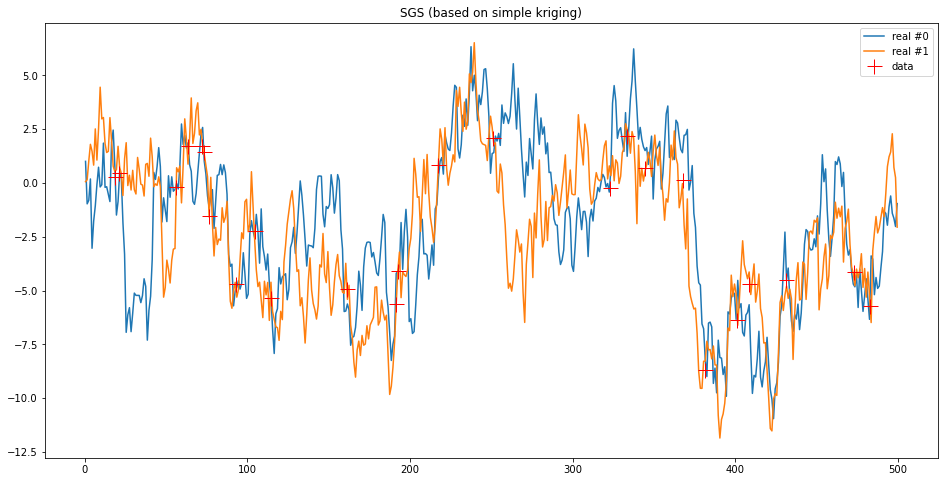

In [18]:
# Define points xu where to simulate
sim_xu = ox + (np.arange(nx/2)+0.5)*2*dx # take less points for simulation

# SGS based on simple kriging
nreal = 2
np.random.seed(321)
sim_vu = gn.covModel.sgs(x, v, sim_xu, cov_model_opt, method='simple_kriging', nreal=nreal)  
# sim_vu:   2-dimensional array of shape (nreal, len(sim_xu)), each row is a realization 
#           (simulated values at locations sim_xu)

# Plot
plt.figure(figsize=(16,8))
plt.plot(sim_xu, sim_vu[0], label='real #0')
plt.plot(sim_xu, sim_vu[1], label='real #1')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.title('SGS (based on simple kriging)')
plt.show()

## Alternatives for kriging estimation and simulation
The module `geone.geosclassicinterface` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_1d` for 1D case):
- function `geone.geosclassicinterface.estimate1D`: estimation in a 1D grid, *i.e.* kriging estimates and standard deviation, for simple or ordinary kriging
- function `geone.geosclassicinterface.simulate1D`: simulation in a 1D grid, based on simple or ordinary kriging; allows also to handle inequality data

The module `geone.grf` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_1d` for 1D case):
- function `geone.grf.krige1D`: estimation a 1D grid, *i.e.* kriging estimates and standard deviation, for simple kriging only
- function `geone.grf.grf1D`: simulation a 1D grid, based on simple kriging only

Note that for these functions, the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

### Examples

### Estimation using the function `geone.covModel.krige`

In [19]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 0.006921052932739258


### Estimation using the function `geone.grf.krige1D`

In [20]:
t1 = time.time()
vu_grf, vu_std_grf = gn.grf.krige1D(x, v, cov_model_opt, nx, dx, ox, printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 0.006798982620239258


### Estimation using the function `geone.geosclassicinterface.estimate1D`

In [21]:
t1 = time.time()
estim_gci = gn.geosclassicinterface.estimate1D(cov_model_opt, nx, dx, ox, x=x, v=v, 
                                               method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20211021 / OpenMP 7 thread(s)]
Geos-Classic run complete
Elapsed time in seconds: 0.030899524688720703


### Plot results of estimation

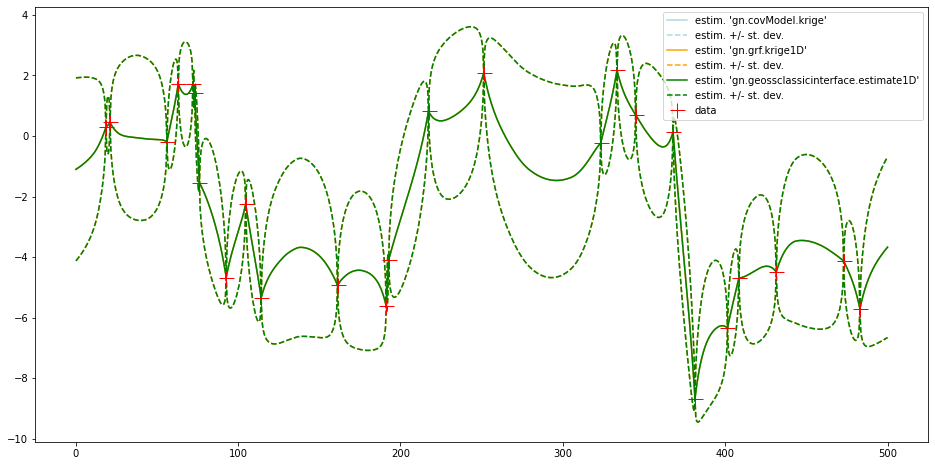

In [22]:
# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, color='lightblue', ls='solid', label="estim. 'gn.covModel.krige'")
plt.plot(xu, vu + vu_std, color='lightblue', ls='dashed', label='estim. +/- st. dev.')
plt.plot(xu, vu - vu_std, color='lightblue', ls='dashed')

plt.plot(xu, vu_grf, color='orange', ls='solid', label="estim. 'gn.grf.krige1D'")
plt.plot(xu, vu_grf + vu_std_grf, color='orange', ls='dashed', label='estim. +/- st. dev.')
plt.plot(xu, vu_grf - vu_std_grf, color='orange', ls='dashed')

vu_gci = estim_gci['image'].val[0,0,0,:]
vu_std_gci = estim_gci['image'].val[1,0,0,:]
x_gci = estim_gci['image'].x()
plt.plot(x_gci, vu_gci, color='green', ls='solid', label="estim. 'gn.geossclassicinterface.estimate1D'")
plt.plot(x_gci, vu_gci + vu_std_gci, color='green', ls='dashed', label='estim. +/- st. dev.')
plt.plot(x_gci, vu_gci - vu_std_gci, color='green', ls='dashed')

plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.show()

In [23]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                     = {}".format(np.ptp(vu - vu_grf)))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu - vu_gci)))
print("Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_grf - vu_gci)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                     = {}".format(np.ptp(vu_std - vu_std_grf)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_std - vu_std_gci)))
print("Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_std_grf - vu_std_gci)))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                     = 3.197442310920451e-14
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = 4.1300296516055823e-14
Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = 4.707345624410664e-14
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                     = 4.21468964725287e-08
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = 4.214686016823579e-08
Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = 7.105427357601002e-14


### Conditional simulation using the function `geone.grf.grf1D`

In [24]:
np.random.seed(293)

t1 = time.time()
nreal = 2000
sim_grf = gn.grf.grf1D(cov_model_opt, nx, dx, ox, x=x, v=v, nreal=nreal, printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 0.4891386032104492


### Conditional simulation using the function `geone.geosclassicinterface.simulate1D`

In [25]:
np.random.seed(293)

t1 = time.time()
nreal = 2000
sim_gci = gn.geosclassicinterface.simulate1D(cov_model_opt, nx, dx, ox, x=x, v=v, nreal=nreal, 
                                             method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20211021 / OpenMP 7 thread(s)]
Geos-Classic run complete
Elapsed time in seconds: 7.105591297149658


### Plot some realizations and compare to the reference simulation

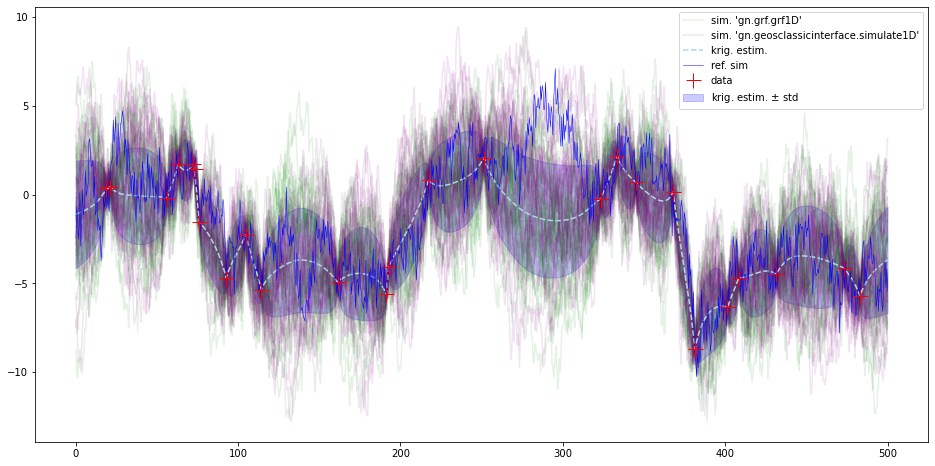

In [26]:
# Plot
plt.figure(figsize=(16,8))
for i in range(30):
    if i == 0:
        label = "sim. 'gn.grf.grf1D'"
    else:
        label = None
    plt.plot(xu, sim_grf[i], color='green', alpha=.1, label=label)
for i in range(30):
    if i == 0:
        label = "sim. 'gn.geosclassicinterface.simulate1D'"
    else:
        label = None
    plt.plot(xu, sim_gci['image'].val[i,0,0,:], color='purple', alpha=.1, label=label)
plt.plot(xu, vu, color='lightblue', ls='dashed', label='krig. estim.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='blue', alpha=0.2, label=r'krig. estim. $\pm$ std')
plt.plot(xu, ref[0], color='blue', lw=.5, label='ref. sim')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.show()